In [1]:
import os
from pathlib import Path
import pickle

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images


In [2]:
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)

In [3]:
dataset = '50'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
class CFG:
    model_type = 'LightGBM'
    popular_num_items = 512
    popular_days = 7
    train_weeks = 1
    repurchase_weeks = 12345
    repurchase_num_items = 123456
    item2item_weeks = 12345
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 20
    dynamic_feature_weeks = 8
    volume_feature_days = 7
    max_num_in_group = 1000 # 1000件以上は打ち切る
    sample_rate = 1.0

# BEST
# class CFG:
#     model_type = 'CatBoost'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 3
#     repurchase_weeks = 123456
#     repurchase_num_items = 123456
#     item2item_weeks = 123456
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7
#     max_num_in_group = 1_000

In [5]:
assert os.path.exists(ARTIFACTS_DIR / f"lfm_{dataset}_{CFG.train_weeks+1}.pkl")
assert os.path.exists(ARTIFACTS_DIR / f"lfm_{dataset}_{CFG.train_weeks}.pkl")

In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
        day_start = 7 * week_start
        tr = transactions.query("@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.popular_num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        # TODO: 元々バグってたので閾値とか要検討
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("cnt > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_category_top(
            strategy: str,
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            week_num: int,
            category: str,
            ) -> pd.DataFrame:
        users = users.copy()
        users['age_segment'] = users['age'] // 10
        tr = transactions.query("@week_start <= week <= @week_start")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', category]], on='item').merge(users[['user', 'age_segment']], on='user')
        category_popular_items = tr.groupby(['item', 'age_segment', category]).size().reset_index(name='cnt')
        category_popular_items['segment_rank'] = category_popular_items.groupby(category)['cnt'].rank(ascending=False, method='dense')
        category_popular_items = category_popular_items.query('segment_rank <= 10')

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = (base_candidates
                      .merge(users[['user', 'age_segment']], on='user')
                      .merge(items[['item', category]], on='item')
                      .drop('item', axis=1)
                      .merge(category_popular_items, on=['age_segment', category])
                      .rename(columns=replace))[['user', 'item', 'segment_rank']]

        candidates['strategy'] = strategy
        return candidates

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week)

    candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)
    cat = 'product_group_name_idx'
    candidates_same_category_top = create_candidates_same_category_top(f'same_{cat}', transactions, users, items, candidates_item2item, week, CFG.item2item_num_items, cat)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)

    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_same_category_top = drop_common_user_item(candidates_same_category_top, candidates_repurchase)
    candidates_same_category_top = drop_common_user_item(candidates_same_category_top, candidates_same_product_code)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_same_category_top,
    ]
    candidates = pd.concat(candidates)

    candidates['row_num'] = candidates.index
    candidates['row_num_in_group'] = candidates.groupby('user')['row_num'].rank(method='dense')
    candidates = candidates.query('row_num_in_group <= @CFG.max_num_in_group')
    del candidates['row_num'], candidates['row_num_in_group']

    # encode strategy
    strategies = (candidates[['strategy']]
                  .drop_duplicates(keep='first')
                  .reset_index(drop=True)
                  .reset_index()
                  .rename(columns={'index': 'strategy_idx'}))
    candidates = candidates.merge(strategies, on='strategy')

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 1
volume: 27330756
duplicates: 1.2329214205532466
                      strategy    volume     ratio
0                          pop  15477950  0.566320
1  same_product_group_name_idx   5844545  0.213845
2            same_product_code   3369129  0.123272
3                   repurchase   1728488  0.063243
4                         cooc    910644  0.033319
week: 2
volume: 28072689
duplicates: 1.2026809547643775
                      strategy    volume     ratio
0                          pop  17267275  0.615092
1  same_product_group_name_idx   4307866  0.153454
2            same_product_code   3552051  0.126530
3                   repurchase   1839442  0.065524
4                         cooc   1106055  0.039400


<AxesSubplot:>

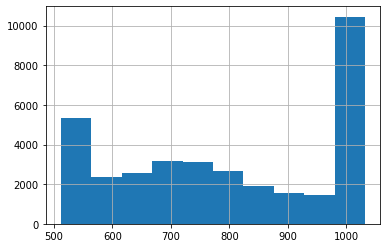

In [8]:
candidates[0].groupby('user').size().hist()

In [9]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [10]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


week: 0
Recall: 0.3318001215350816
                      strategy        y    volume    recall  hit_ratio
0                          pop  28758.0  15477950  0.268854   0.001858
1  same_product_group_name_idx  13714.0   5844545  0.128210   0.002346
2                   repurchase   4312.0   1728488  0.040312   0.002495
3            same_product_code   3998.0   3369129  0.037377   0.001187
4                         cooc   3478.0    910644  0.032515   0.003819
week: 1
Recall: 0.3305761201361356
                      strategy        y    volume    recall  hit_ratio
0                          pop  31301.0  17267275  0.274561   0.001813
1  same_product_group_name_idx  13934.0   4307866  0.122224   0.003235
2                   repurchase   4525.0   1839442  0.039692   0.002460
3            same_product_code   4206.0   3552051  0.036893   0.001184
4                         cooc   3423.0   1106055  0.030025   0.003095


In [11]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df

def sample_user(df):
    users = df[['user']].drop_duplicates().sample(frac=CFG.sample_rate)
    df = df.merge(users, on='user')
    return df

for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])
    candidates[idx] = sample_user(candidates[idx])

drop trivial queries: 27330756 -> 15504842
drop trivial queries: 28072689 -> 16388953


In [12]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
    tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    day_start = 7 * week
    day_end = day_start + CFG.volume_feature_days
    tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
    # tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
    # df = df.merge(tmp, on='user', how='left')

    # user volume features
    # day_start = 7 * week
    # day_end = day_start + CFG.volume_feature_days
    # tmp = transactions.query("@day_start <= day < @day_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
    tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    day_start = 7 * week
    day_end = day_start + CFG.volume_feature_days
    tmp = transactions.query("@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    # lfm features
    lfm_path = ARTIFACTS_DIR / f"lfm_{dataset}_{pretrain_week}.pkl"

    with open(lfm_path, 'rb') as f:
        lfm = pickle.load(f)
    no_components = lfm.get_params()['no_components']

    # df['lfm'] = lfm.predict(df['user'].values, df['item'].values, num_threads=psutil.cpu_count(logical=False))

    user_reps = np.hstack([lfm.user_embeddings, lfm.user_biases.reshape((len(users), 1))])
    user_reps = pd.DataFrame(user_reps, columns=[f'user_rep_{i}' for i in range(no_components+1)])
    user_reps = pd.concat([pd.DataFrame({'user': range(len(users))}), user_reps], axis=1)
    df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

week: 1
week: 1
week: 2


In [13]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [14]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [15]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'segment_rank', 'strategy_idx', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_item_day_min', 'user_item_volume', 'user_rep_0', 'user_rep_1', 'user_rep_2', 'user_rep_3', 'user_rep_4', 'user_rep_

In [16]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['strategy_idx', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [17]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

[LightGBM] [Info] Total groups: 20820, total data: 16388953
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.094874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10468
[LightGBM] [Info] Number of data points in the train set: 16388953, number of used features: 60
[LightGBM] [Info] Total groups: 19586, total data: 15504842
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	training's map@12: 0.10283	valid_1's map@12: 0.0718632


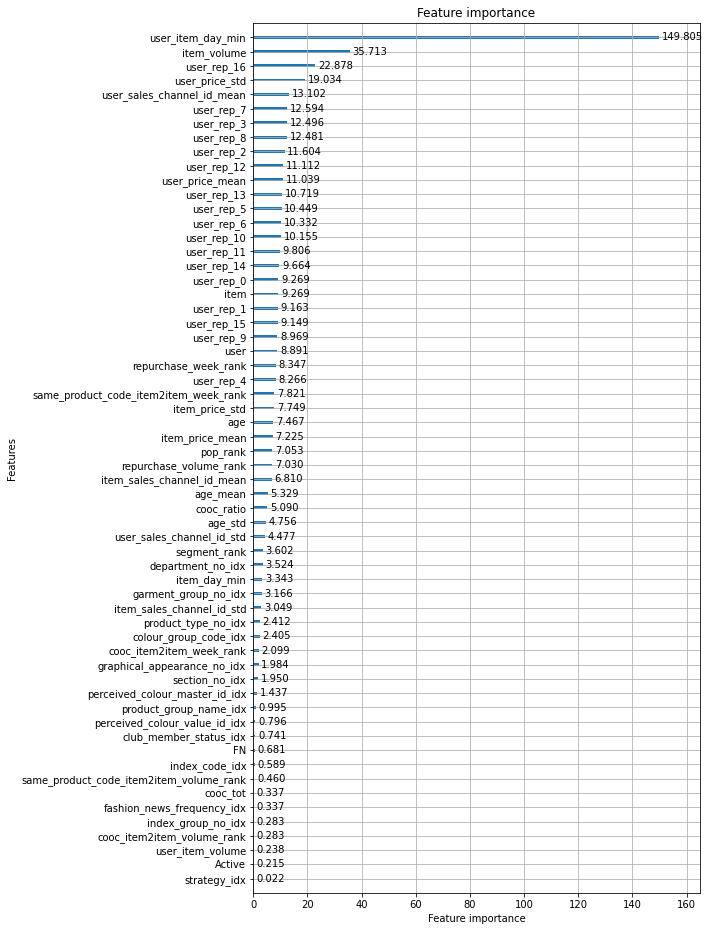

In [18]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
    }
    model = catboost.CatBoost(params)
    model.fit(train_pool, eval_set=valid_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [19]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

In [20]:
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

In [21]:
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

print('mAP@12:', mapk(merged['gt'], merged['item']))

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

mAP@12: 0.03213600305870806


In [22]:
assert False

AssertionError: 

submission

In [ ]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

In [ ]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [ ]:
all_users = users['user'].values
all_users

In [ ]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)